In [1]:
from gnn_tracking_hpo.trainable import GCTrainable

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
plt.style.use('sss1.mplstyle')

In [68]:
trainable = GCTrainable.reinstate("gc", "0e7cb526", epoch=-1)

[17:52:31 HPO] DEBUG: Loading config from /home/kl5675/ray_results/gc/LWSGCTrainable_0e7cb526_1_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_weight_deca_2023-06-01_10-59-36/params.json
[17:52:31 HPO] INFO: I'm running on a node with job ID=48200783
[17:52:31 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[17:52:31 HPO] INFO: The ID of my dispatcher is 0
[17:52:31 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[17:52:31 HPO] DEBUG: Got config
┌───────────────────────────────┬──────────────────────────────────────────┐
│ _val_batch_size               │ 1                                        │
│ adam_amsgrad                  │ False                                    │
│ adam_beta1                    │ 0.9                                      │
│ adam_beta2                    │ 0.999                                    │
│ adam_eps

In [69]:
data = trainable.trainer.val_loader.dataset[0]

In [70]:
mo = trainable.trainer.evaluate_model(data)

In [19]:
x = mo["x"].detach().cpu().numpy()

In [6]:
list(mo.keys())

['w',
 'x',
 'beta',
 'pred',
 'ec_hit_mask',
 'ec_edge_mask',
 'y',
 'particle_id',
 'track_params',
 'pt',
 'reconstructable',
 'edge_index',
 'sector',
 'node_features']

In [12]:
df = pd.DataFrame(x)

In [18]:
eta = data.x.detach().cpu().numpy()[:, 3]

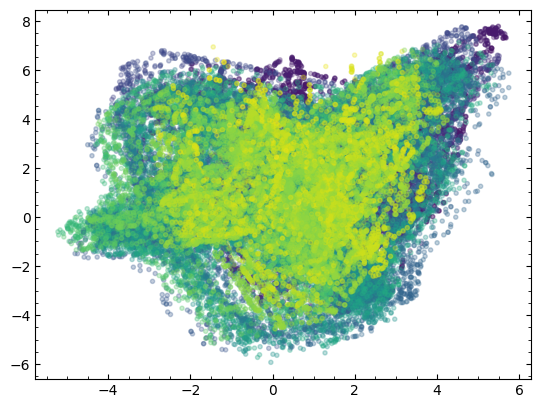

In [26]:
plt.scatter(x[:, 0], x[:, 10], c=eta, alpha=0.3, marker=".")

In [2]:
from tqdm import tqdm
from gnn_tracking.analysis.graphs import get_largest_segment_fracs
from gnn_tracking.graph_construction.radius_scanner import construct_graph

In [17]:

def summarize_ls(ls):
    return {
        "frac_segment50": np.mean(ls > 0.5),
        "frac_segment75": np.mean(ls > 0.75),
        "frac_segment100": np.mean(ls == 1.0),
    }

In [16]:

stats = []
rs = np.linspace(0.3, 5, 10)
for r in tqdm(rs):
    data = construct_graph(mo, r, max_num_neighbors=256)
    if data.num_edges > 5e7:
        break
    stats.append(summarize_ls(get_largest_segment_fracs(data)) | {"n_edges": data.num_edges, "r": r})
stats = pd.DataFrame.from_records(stats)

  0%|                                                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]


NameError: name 'mo' is not defined

In [42]:
def plot_segment_stats(stats):
    fig, ax = plt.subplots()
    ax.plot("r", "frac_segment50", data=stats, label="50%")
    ax.plot("r", "frac_segment75", data=stats, label="75%")
    ax.plot("r", "frac_segment100", data=stats, label="100%")
    ax2 = ax.twinx()
    ax2.plot("r", "n_edges", data=stats, label="n_edges", color="k", linestyle="dashed")
    ax.legend()
    ax2.legend()
    ax.set_xlabel("radius")

In [3]:
import matplotlib.pyplot as plt
# plt.style.use("/home/kl5675/Documents/23/git_sync/klieret-gnn-tracking-experiments/notebooks/sss1.mplstyle")



In [4]:
from torch_geometric.data import Data
from torch_cluster import knn_graph
import typing


def construct_graph_knn(mo: dict[str, typing.Any], k, max_edges=5e7):
    edge_index = knn_graph(mo["x"], k)
    if edge_index.shape[1] > max_edges:
        raise RuntimeError(f"Too many edges: {edge_index.shape[1]}")
    y: Tensor = (  # type: ignore
        mo["particle_id"][edge_index[0, :]] == mo["particle_id"][edge_index[1, :]]
    )
    data = Data(x=mo["x"], edge_index=edge_index, y=y)
    data.pt = mo["particle_id"]
    data.particle_id = mo["particle_id"]
    return data

In [57]:
stats = []
ks = np.linspace(5, 200, 10)
for k in tqdm(ks):
    try:
        data = construct_graph_knn(mo, int(k), max_edges=1e8)
    except RuntimeError as e:
        print("Break", e)
        break
    stats.append(summarize_ls(get_largest_segment_fracs(data)) | {"n_edges": data.num_edges, "r": k})
stats = pd.DataFrame.from_records(stats)

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 5/10 [00:18<00:18,  3.75s/it]

Break The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_cluster/knn.py", line 115, in knn_graph

    assert flow in ['source_to_target', 'target_to_source']
    edge_index = knn(x, x, k if loop else k + 1, batch, batch, cosine,
                 ~~~ <--- HERE
                     num_workers)
  File "/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_cluster/knn.py", line 72, in knn
        ptr_y = torch.bucketize(arange, batch_y)

    return torch.ops.torch_cluster.knn(x, y, ptr_x, ptr_y, k, cosine,
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
                                       num_workers)
RuntimeError: k <= 100 INTERNAL ASSERT FAILED at "csrc/cuda/knn_cuda.cu":98, please report a bug to PyTorch. `k` needs to smaller than or equal to 100



In [5]:
def get_max_knn_stats(project, hash, epoch=-1):
    trainable = GCTrainable.reinstate(project, hash, epoch=epoch)
    pc = trainable.trainer.val_loader.dataset[0]
    mo = trainable.trainer.evaluate_model(pc)
    data = construct_graph_knn(mo, 99, max_edges=1e8)
    return summarize_ls(get_largest_segment_fracs(data)) | {"n_edges": data.num_edges, "k": 99, "hash": hash, "epoch": epoch, "project": project}

In [7]:
from pathlib import Path

In [11]:

dirs = [p for p in Path("/home/kl5675/ray_results/gc").iterdir() if p.is_dir()]

In [12]:
import logging

logging.disable(logging.CRITICAL)

In [13]:
results = []
broken = []

In [ ]:

for d in tqdm(dirs):
    hash = d.name.split("_")[1]
    available_epochs = [int(p.name.split("checkpoint_")[1]) for p in d.iterdir() if p.name.startswith("checkpoint_")]
    for epoch in available_epochs:
        try:
            result = get_max_knn_stats("gc", hash, epoch=epoch)
        except Exception as e:
            print(e)
            broken.append({
                "hash": hash,
                "epoch": epoch,
                "error": e,
            })
        results.append(result)

  1%|█                                                                                                                                                                                                           | 2/370 [01:04<3:18:02, 32.29s/it]

Error(s) in loading state_dict for MetricLearningGraphConstruction:
	Missing key(s) in state_dict: "_layer_norm.weight", "_layer_norm.bias", "_encoder1.layers.0.weight", "_encoder1.layers.0.bias", "_encoder1.layers.2.weight", "_encoder1.layers.2.bias", "_encoder1.layers.4.weight", "_encoder1.layers.4.bias", "_encoder2.layers.0.weight", "_encoder2.layers.0.bias", "_encoder2.layers.2.weight", "_encoder2.layers.2.bias", "_encoder2.layers.4.weight", "_encoder2.layers.4.bias", "_beta_nn.layers.0.weight", "_beta_nn.layers.0.bias", "_beta_nn.layers.2.weight", "_beta_nn.layers.2.bias", "_latent.layers.0.weight", "_latent.layers.0.bias", "_latent.layers.2.weight", "_latent.layers.2.bias". 
	Unexpected key(s) in state_dict: "encoder.layers.0.weight", "encoder.layers.0.bias", "encoder.layers.2.weight", "encoder.layers.2.bias", "encoder.layers.4.weight", "encoder.layers.4.bias", "encoder.layers.6.weight", "encoder.layers.6.bias", "encoder.layers.8.weight", "encoder.layers.8.bias", "encoder.layers.

  1%|█▋                                                                                                                                                                                                          | 3/370 [01:05<1:49:04, 17.83s/it]

Error(s) in loading state_dict for MetricLearningGraphConstruction:
	Missing key(s) in state_dict: "_layer_norm.weight", "_layer_norm.bias", "_encoder1.layers.0.weight", "_encoder1.layers.0.bias", "_encoder1.layers.2.weight", "_encoder1.layers.2.bias", "_encoder1.layers.4.weight", "_encoder1.layers.4.bias", "_encoder2.layers.0.weight", "_encoder2.layers.0.bias", "_encoder2.layers.2.weight", "_encoder2.layers.2.bias", "_encoder2.layers.4.weight", "_encoder2.layers.4.bias", "_beta_nn.layers.0.weight", "_beta_nn.layers.0.bias", "_beta_nn.layers.2.weight", "_beta_nn.layers.2.bias", "_latent.layers.0.weight", "_latent.layers.0.bias", "_latent.layers.2.weight", "_latent.layers.2.bias". 
	Unexpected key(s) in state_dict: "encoder.layers.0.weight", "encoder.layers.0.bias", "encoder.layers.2.weight", "encoder.layers.2.bias", "encoder.layers.4.weight", "encoder.layers.4.bias", "encoder.layers.6.weight", "encoder.layers.6.bias", "encoder.layers.8.weight", "encoder.layers.8.bias", "encoder.layers.

  1%|██▊                                                                                                                                                                                                           | 5/370 [01:05<47:27,  7.80s/it]

'max_sample_size'
'max_sample_size'
'max_sample_size'


  2%|████▍                                                                                                                                                                                                       | 8/370 [02:36<2:16:01, 22.55s/it]

Error(s) in loading state_dict for MetricLearningGraphConstruction:
	Missing key(s) in state_dict: "_layer_norm.weight", "_layer_norm.bias", "_encoder1.layers.0.weight", "_encoder1.layers.0.bias", "_encoder1.layers.2.weight", "_encoder1.layers.2.bias", "_encoder1.layers.4.weight", "_encoder1.layers.4.bias", "_encoder2.layers.0.weight", "_encoder2.layers.0.bias", "_encoder2.layers.2.weight", "_encoder2.layers.2.bias", "_encoder2.layers.4.weight", "_encoder2.layers.4.bias", "_beta_nn.layers.0.weight", "_beta_nn.layers.0.bias", "_beta_nn.layers.2.weight", "_beta_nn.layers.2.bias", "_latent.layers.0.weight", "_latent.layers.0.bias", "_latent.layers.2.weight", "_latent.layers.2.bias". 
	Unexpected key(s) in state_dict: "encoder.layers.0.weight", "encoder.layers.0.bias", "encoder.layers.2.weight", "encoder.layers.2.bias", "encoder.layers.4.weight", "encoder.layers.4.bias", "encoder.layers.6.weight", "encoder.layers.6.bias", "encoder.layers.8.weight", "encoder.layers.8.bias", "encoder.layers.

  2%|████▉                                                                                                                                                                                                       | 9/370 [02:36<1:36:18, 16.01s/it]

Error(s) in loading state_dict for MetricLearningGraphConstruction:
	Missing key(s) in state_dict: "_layer_norm.weight", "_layer_norm.bias", "_encoder1.layers.0.weight", "_encoder1.layers.0.bias", "_encoder1.layers.2.weight", "_encoder1.layers.2.bias", "_encoder1.layers.4.weight", "_encoder1.layers.4.bias", "_encoder2.layers.0.weight", "_encoder2.layers.0.bias", "_encoder2.layers.2.weight", "_encoder2.layers.2.bias", "_encoder2.layers.4.weight", "_encoder2.layers.4.bias", "_beta_nn.layers.0.weight", "_beta_nn.layers.0.bias", "_beta_nn.layers.2.weight", "_beta_nn.layers.2.bias", "_latent.layers.0.weight", "_latent.layers.0.bias", "_latent.layers.2.weight", "_latent.layers.2.bias". 
	Unexpected key(s) in state_dict: "encoder.layers.0.weight", "encoder.layers.0.bias", "encoder.layers.2.weight", "encoder.layers.2.bias", "encoder.layers.4.weight", "encoder.layers.4.bias", "encoder.layers.6.weight", "encoder.layers.6.bias", "encoder.layers.8.weight", "encoder.layers.8.bias", "encoder.layers.

  3%|█████▍                                                                                                                                                                                                     | 10/370 [02:36<1:07:55, 11.32s/it]

'max_sample_size'
'max_sample_size'
'max_sample_size'


In [ ]:
results

In [ ]:
import json

In [ ]:
with open("results.json", "w") as f:
    json.dump(results, f)

In [110]:
! cat results.json

ValueError: filedescriptor out of range in select()